# Signature MMD Two-Sample Statistical Tests

## Numerical Examples - Autoregressive Time Series Models

### Andrew Alden, Blanka Horvath, Zacharia Issa

## Table of Contents:
* [Model Setup](#env-setup)
* [Two-Sample Hypothesis Test](#two-sample)
* [Apply Scaling](#scaling)
* [Level Contributions](#lvl-contrib)
* [Relationship between Scaling, Batch Size, and Errors](#batchsize-scaling)

In [2]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [ ]:
import math
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import arch
import pandas as pd
import seaborn as sns
import pickle
from collections import defaultdict

from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.plotting_functions import plot_dist, plot_level_contributions, plot_type2_error, plot_type1_error, plot_aggregate_type1_error, plot_dist_boxen
from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error, get_level_values, generate_error_probs_linear_kernel
from src.mmd.level_functions import lambda_k, level_k_contribution, mmd_est_k
from src.mmd.signature_functions import get_level_k_signatures_from_paths
from src.mmd.level_functions import lambda_k, gramda_k
from src.mmd.mmd import SigKernel, RBFKernel, LinearKernel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Model Setup <a class="anchor" id="env-setup"></a>

In [4]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

In [5]:
def sim_garch_model(model, sim, num_sim, num_time_steps, T):
    time_steps = np.linspace(0, T, num_time_steps)
    R = np.ones((num_time_steps, num_sim))
    for i in tqdm(range(num_sim)):
        R[:, i] = sim.simulate(model.params, num_time_steps).data.values
    return np.concatenate((R[:, :, None], np.repeat(np.asarray(time_steps)[:, None, None], repeats=num_sim, axis=1)), axis=2)

In [6]:
sim1 = arch.arch_model(np.random.uniform(0, 1, size=(10000,)), vol='GARCH', p=1, q=1, rescale=False)
model_sp1 = sim1.fit()
model_sp1.params[0] = 0.001
model_sp1.params[1] = 0.0038
model_sp1.params[2] = 0.04
model_sp1.params[3] = 0.042

sim2 = arch.arch_model(np.random.uniform(0, 1, size=(10000,)), vol='GARCH', p=1, q=1, rescale=False)
model_sp2 = sim2.fit()
model_sp2.params[0] = 0.005
model_sp2.params[1] = 0.0053
model_sp2.params[2] = 0.08
model_sp2.params[3] = 0.01

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33946.69599538947
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5822550.600198136
Iteration:      3,   Func. Count:     24,   Neg. LLF: 8908.049003743221
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1850.5844931077634
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1850.1133485577243
Iteration:      6,   Func. Count:     46,   Neg. LLF: 1850.1117342787234
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1850.1117342787234
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 22400.395922575797
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56418170534.525696
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1744.5627898843131
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1744.2899604042632
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1744.289664

In [7]:
T = 1
grid_points = 20
path_bank_size = 10000


h0_path_bank = sim_garch_model(model_sp1, sim1, path_bank_size, grid_points, T)
h1_path_bank = sim_garch_model(model_sp2, sim2, path_bank_size, grid_points, T)

h0_paths = torch.transpose(torch.from_numpy(h0_path_bank), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(h1_path_bank), 0, 1).to(device=device)

for i in range(path_bank_size):
    h0_paths[i, :, :] = h0_paths[i, :, :] - h0_paths[i, 0, :]
    h1_paths[i, :, :] = h1_paths[i, :, :] - h1_paths[i, 0, :]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 201.62it/s]


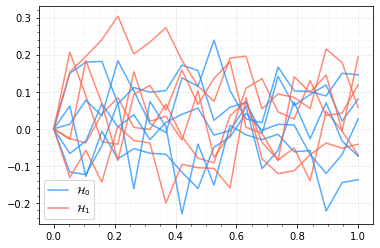

In [8]:
n_plot_paths = 5

label_first = True

for p0, p1 in zip(h0_paths[:n_plot_paths].cpu(), h1_paths[:n_plot_paths].cpu()):
    plt.plot(p0[:, 1], (p0[:, 0] - p0[0, 0]), color="dodgerblue", alpha=0.75, label = "$\mathcal{H}_0$" if label_first else "")
    plt.plot(p1[:, 1], (p1[:, 0] - p1[0, 0]), color="tomato", alpha=0.75, label = "$\mathcal{H}_1$" if label_first else "")
    label_first = False
plt.legend()
make_grid()

### Two-Sample Hypothesis Test <a class="anchor" id="two-sample"></a>

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.90it/s]


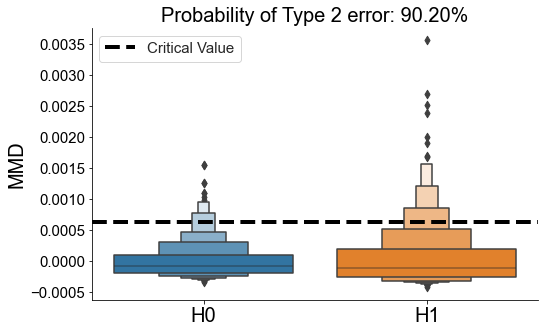

In [9]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', filename='type_2_dist_no_scaling_garch.svg', svg=True)


### Apply scaling <a class="anchor" id="scaling"></a>

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.69it/s]


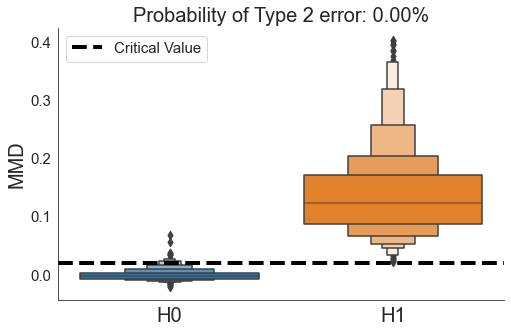

In [10]:
n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 5.5

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)


df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', filename=f'type_2_dist_no_scaling_garch_{scaling}.svg', svg=True)

### Level Contributions <a class="anchor" id="lvl-contrib"></a>

In [10]:
ks = [1, 2, 3, 4, 5, 6]

n_atoms = 500
n_paths = 128

scaling = 5.5


h0_Mk_vals_scaling, h1_Mk_vals_scaling = get_level_values(torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
                                                          torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]),
                                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals_scaling = np.asarray(h0_Mk_vals_scaling)
h1_Mk_vals_scaling = np.asarray(h1_Mk_vals_scaling)

h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:56<00:00,  8.81it/s]


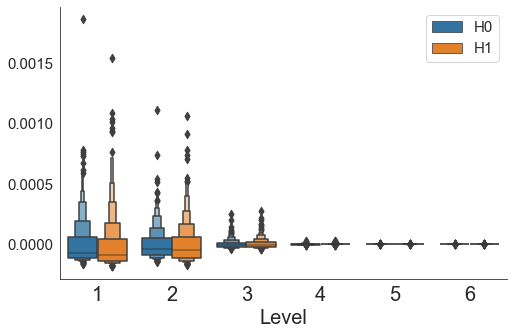

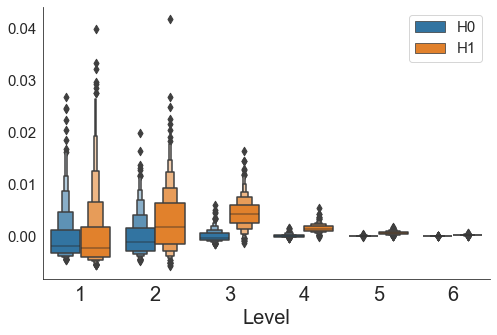

In [11]:
df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 'MMD': np.concatenate((h0_Mk_vals.flatten(), h1_Mk_vals.flatten()))})
plot_dist_boxen(df, 'Level', 'MMD', hue='H', x_label='Level', filename=f'type_2_dist_no_scaling_garch_level_contrib.svg', svg=True)

df_scaling = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * len(ks))] + ['H1' for _ in range(n_atoms * len(ks))], 'Level': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in ks]).flatten(), 2), 'MMD': np.concatenate((h0_Mk_vals_scaling.flatten(), h1_Mk_vals_scaling.flatten()))})
plot_dist_boxen(df_scaling, 'Level', 'MMD', hue='H', x_label='Level', filename=f'type_2_dist_scaling_garch_level_contrib_{scaling}.svg', svg=True)

In [9]:
ks = [1, 4, 6]

n_atoms = 500
n_paths = 128

h0_Mk_vals_scaling_dict = {}
h1_Mk_vals_scaling_dict = {}
for scaling in [0.5, 2, 4, 6, 8]:
    h0_Mk_vals_scaling, h1_Mk_vals_scaling = get_level_values(torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
                                                              torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
                                                              n_atoms, n_paths, ks, path_bank_size)
    h0_Mk_vals_scaling = np.asarray(h0_Mk_vals_scaling)
    h1_Mk_vals_scaling = np.asarray(h1_Mk_vals_scaling)
    h0_Mk_vals_scaling_dict[scaling] = h0_Mk_vals_scaling
    h1_Mk_vals_scaling_dict[scaling] = h1_Mk_vals_scaling

h0_Mk_vals, h1_Mk_vals = get_level_values(torch.multiply(torch.Tensor([1, 1]).to(device=device), h0_paths[:, :, :]), 
                                          torch.multiply(torch.Tensor([1, 1]).to(device=device), h1_paths[:, :, :]), 
                                          n_atoms, n_paths, ks, path_bank_size)
h0_Mk_vals = np.asarray(h0_Mk_vals)
h1_Mk_vals = np.asarray(h1_Mk_vals)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.29it/s]


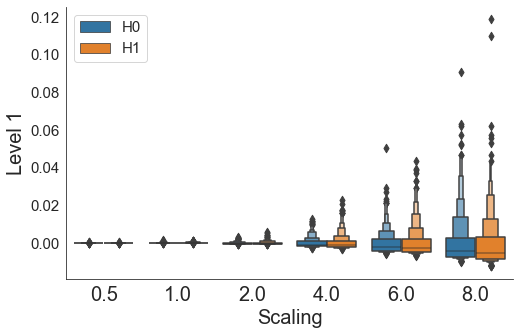

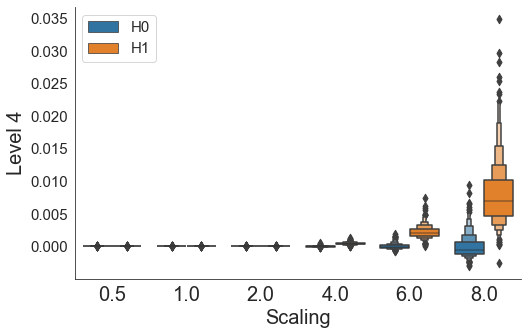

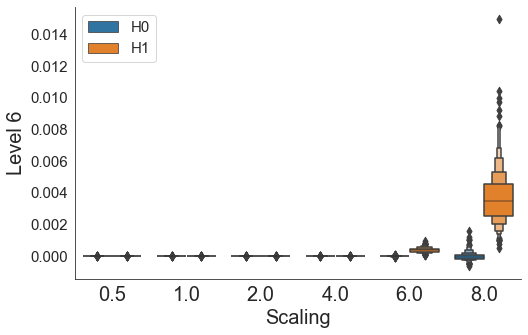

In [11]:
scalings = [1, 0.5, 2, 4, 6, 8]
for i, lvl in enumerate([1, 4, 6]):
    df = pd.DataFrame({'H': ['H0' for _ in range(n_atoms * 6)] + ['H1' for _ in range(n_atoms * 6)],
                       'Scaling': np.tile(np.asarray([[i for _ in range(n_atoms)] for i in scalings]).flatten(), 2),
                       'Contrib': np.concatenate((np.concatenate((h0_Mk_vals[i, :], np.asarray(list(h0_Mk_vals_scaling_dict.values()))[:, i, :].flatten())), np.concatenate((h1_Mk_vals[i, :], np.asarray(list(h1_Mk_vals_scaling_dict.values()))[:, i, :].flatten()))))})
    plot_dist_boxen(df, 'Scaling', 'Contrib', hue='H', y_label=f'Level {lvl}', x_label='Scaling', filename=f'type_2_dist_no_scaling_garch_level_{lvl}.svg', svg=True)


### Relationship between Scaling, Batch Size, and Errors <a class="anchor" id="batchsize-scaling"></a>

In [3]:
scalings = np.linspace(0, 5, 20)
n_atoms   = 100
n_paths_list   = [20, 40, 60, 120]
alpha = 0.05

In [ ]:
num_sim = 100
type1_list_unbiased, type2_list_unbiased = generate_error_probs_linear_kernel(signature_kernel,
                                                                              h0_paths,
                                                                              h1_paths,
                                                                              n_atoms, 
                                                                              n_paths_list, 
                                                                              alpha, 
                                                                              scalings,
                                                                              'ub', 
                                                                              num_sim, 
                                                                              device, 
                                                                              filename='garch_unbiased',
                                                                              folder='GARCHData')

type1_list_biased, type2_list_biased = generate_error_probs_linear_kernel(signature_kernel, 
                                                                          h0_paths, 
                                                                          h1_paths, 
                                                                          n_atoms,
                                                                          n_paths_list, 
                                                                          alpha,
                                                                          scalings, 
                                                                          'b', 
                                                                          num_sim, 
                                                                          device, 
                                                                          filename='garch_biased',
                                                                          folder='GARCHData')

In [4]:
with open("GARCHData/type1error_garch_unbiased", "rb") as fp: 
    type1_list_unbiased = pickle.load(fp)

with open("GARCHData/type2error_garch_unbiased", "rb") as fp: 
    type2_list_unbiased = pickle.load(fp)

with open("GARCHData/type1error_garch_biased", "rb") as fp: 
    type1_list_biased = pickle.load(fp)

with open("GARCHData/type2error_garch_biased", "rb") as fp: 
    type2_list_biased = pickle.load(fp)

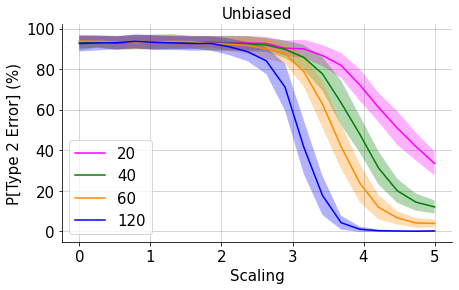

In [6]:
plot_type2_error(type2_list_unbiased, scalings, n_paths_list, title='Unbiased')

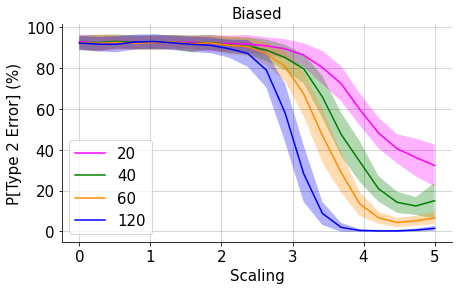

In [8]:
plot_type2_error(type2_list_biased, scalings, n_paths_list, title='Biased')

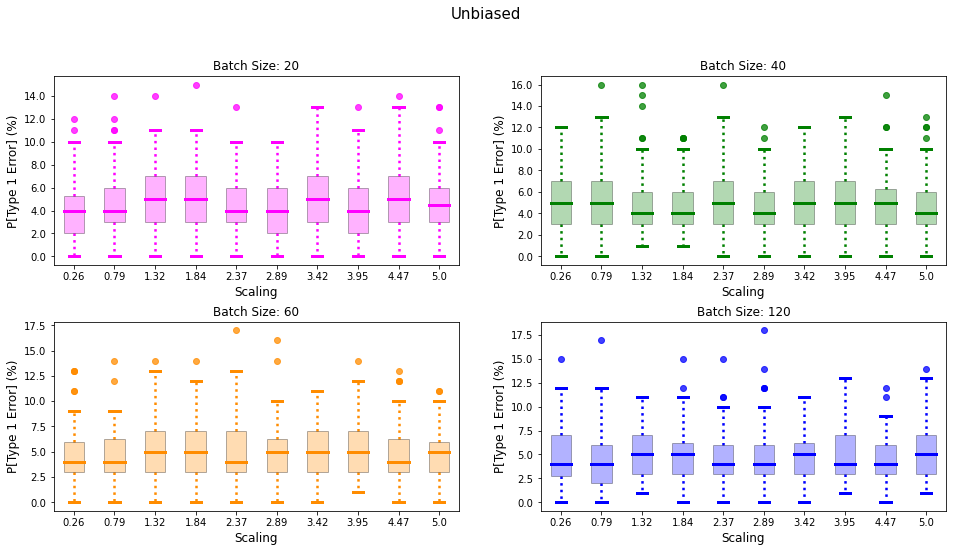

In [10]:
plot_type1_error(type1_list_unbiased, scalings, n_paths_list, title='Unbiased')

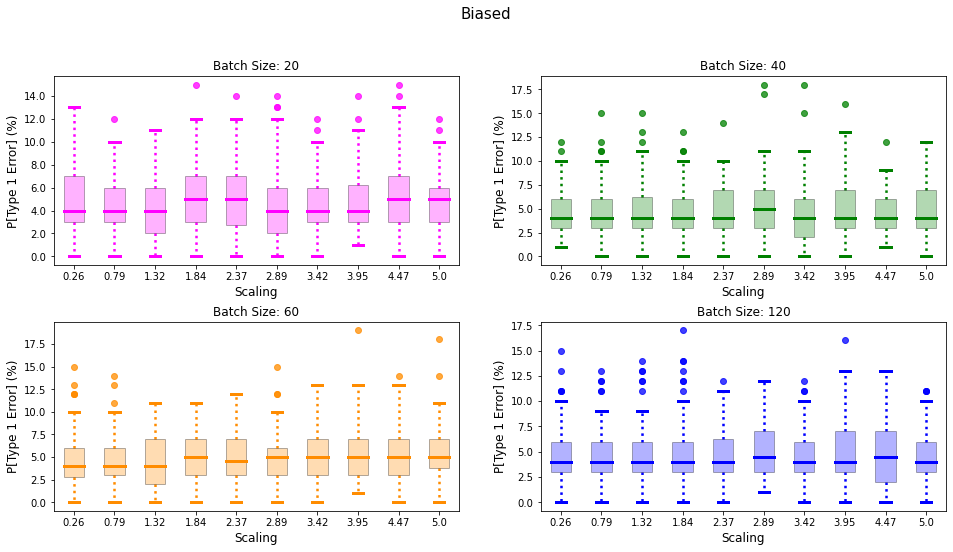

In [9]:
plot_type1_error(type1_list_biased, scalings, n_paths_list, title='Biased')